### Modules

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

import pickle
import requests, os, sys

from sklearn import model_selection
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.cluster import DBSCAN, KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import linear_model, svm, naive_bayes, neighbors, ensemble

import xgboost as xgb

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_seq_items', 1000)
%matplotlib inline

# Data

### Data

In [2]:
# calling bitcoin heist data
df = pd.read_csv('../../../data/external/BitcoinHeistData.csv').rename(columns = {'label':'ransomware'})

### Analyze ransomwares

In [ ]:
# find list of ransomwares
ransomwares = df.ransomware.unique().tolist()

ransomwares

In [ ]:
# make a dataframe showing the counts of each ransomware with the average of some values


# make a dataframe showing the counts of each ransomware with the average of some values
aggregate_ransom_df = df.groupby('ransomware').agg({'address': 'count', 
                                     'year': ['min', 'max'],
                                     'length': 'mean',
                                     'weight': 'mean',
                                     'count': 'mean',
                                     'looped': 'mean',
                                     'neighbors': 'mean',
                                     'income': ['mean', 'sum'],}).sort_values(by=[('address', 'count')], ascending=False)

aggregate_ransom_df.head(6)

### Ransomware distribution

In [3]:
select_list = ['princetonCerber',
                 'princetonLocky',
                 'montrealCryptoLocker',
                 'montrealCryptXXX',
                 'paduaCryptoWall']

select_df = df[df['ransomware'].isin(select_list)]

In [ ]:
# select_df.address.count()/ransom_df.address.count()*100

### Custering

In [ ]:
cluster_df = aggregate_ransom_df[[('length', 'mean'), 
                                  ('weight', 'mean'),
                                  ('count', 'mean'), 
                                  ('looped', 'mean'), 
                                  ('neighbors', 'mean'), 
                                  ('income', 'mean')]].iloc[:6,:]

In [ ]:
X = np.array(cluster_df)

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
clustering = DBSCAN(eps=2, min_samples=2).fit(X)

clustering.labels_

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=11).fit(X)

kmeans.labels_

In [ ]:
list(zip(aggregate_ransom_df.index, kmeans.labels_))

### Analyze income of payments

In [ ]:
# isolate ransomware payments
ransomware_list = ['princetonCerber',
                     'princetonLocky',
                     'montrealCryptoLocker',
                     'montrealCryptXXX',
                     'paduaCryptoWall',
                     'montrealWannaCry',
                     'montrealDMALockerv3',
                     'montrealCryptoTorLocker2015',
                     'montrealSamSam',
                     'montrealFlyper',
                     'montrealNoobCrypt',
                     'montrealDMALocker',
                     'montrealGlobe',
                     'montrealEDA2',
                     'paduaKeRanger',
                     'montrealVenusLocker',
                     'montrealXTPLocker',
                     'paduaJigsaw',
                     'montrealGlobev3',
                     'montrealJigSaw',
                     'montrealXLockerv5.0',
                     'montrealXLocker',
                     'montrealRazy',
                     'montrealCryptConsole',
                     'montrealGlobeImposter',
                     'montrealSam',
                     'montrealComradeCircle',
                     'montrealAPT']

ransom_df = df[df['ransomware'].isin(ransomware_list)]

ransom_df.shape

In [ ]:
len(ransomware_list)

In [ ]:
# find average ransomware payment in dollars (data is recorded in sartoshis)
(ransom_df.income.mean()/100000000)*10373

In [ ]:
ransom_avg = pd.DataFrame(ransom_df.mean()).T

In [ ]:
ransom_avg

In [ ]:
white_avg = pd.DataFrame(df[df['ransomware'] == 'white'].mean()).T

In [ ]:
pd.concat([ransom_avg, white_avg])

### Vizualization

In [4]:
common_ransom_list = ['princetonCerber',
 'princetonLocky',
 'montrealCryptoLocker',
 'montrealCryptXXX',
 'paduaCryptoWall']

common_ransom_df = df[df['ransomware'].isin(common_ransom_list)]

common_ransom_df.shape

(39972, 10)

In [9]:
common_ransom_df = common_ransom_df[(common_ransom_df['year'] >= 2013) & (common_ransom_df['year'] <= 2017)]

common_ransom_df.shape

(39193, 11)

In [10]:
common_ransom_df['date'] = common_ransom_df['year']*365 + common_ransom_df['day']

In [11]:
common_ransom_df.head()

,address,year,day,length,weight,count,looped,neighbors,income,ransomware,date
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,18,0.008333,1,0,2,100050000.0,princetonCerber,736216
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,44,0.000244,1,0,1,100000000.0,princetonLocky,735972
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,246,0,1.000000,1,0,2,200000000.0,princetonCerber,736086
3,1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7,2016,322,72,0.003906,1,0,2,71200000.0,princetonCerber,736162
4,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,0.072848,456,0,1,200000000.0,princetonLocky,736078


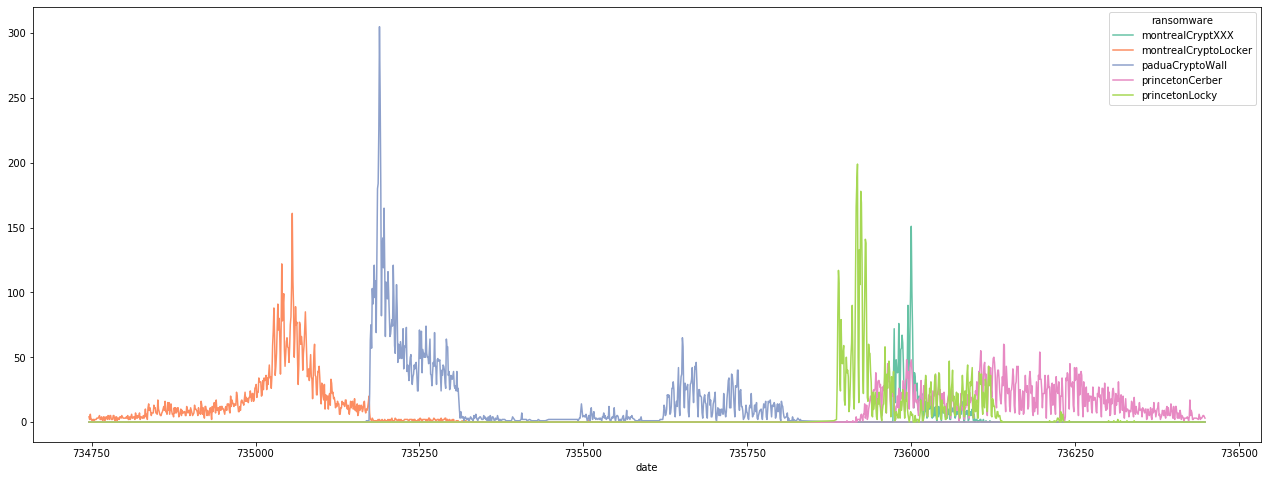

In [13]:
terror_region=pd.crosstab(common_ransom_df.date,df.ransomware)
terror_region.plot(color=sns.color_palette('Set2',12))
fig=plt.gcf()
fig.set_size_inches(22,8)
plt.show()

In [14]:
735250/365

2014.3835616438357

In [18]:
2017*365

736205